In [ ]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import display

# Task 1 - Simulate the dynamics of cat qubits at the effective Hamiltonian level

## Task 1.1: Getting Started with Dynamiqs

The goal of this task is to simulate the time-evolution of a dissipatively stabilised cat qubit system using `dynamiqs`. The system consists of a memory mode coupled to a lossy buffer mode, with an interaction that exchanges two photons of the memory mode with one photon in the buffer mode.

### Hamiltonian

The Hamiltonian of the system is given by:

$$
\begin{aligned}
\hat{H} &= \hat{H}_{\mathrm{2ph}} + \hat{H}_d,\qquad \mathrm{with}\\
\hat{H}_{\mathrm{2ph}} &= g_2 {{}\hat{a}^\dagger}^2 \hat{b} + g_2^* \hat{a}^2 \hat{b}^\dagger,\\
\hat{H}_d &= \epsilon_d^* \hat{b} + \epsilon_d \hat{b}^\dagger.
\end{aligned}
$$

where $\hat{H}_{\mathrm{2ph}}$ is the two-photon exchange Hamiltonian and $\hat{H}_d$ is the buffer drive Hamiltonian.

The system's dynamics dynamics are governed by the Lindblad master equation, which describes the time evolution of the density matrix $\hat{\rho}$ under both unitary and dissipative processes:

$$
\begin{aligned}
\frac{d \hat{\rho}}{dt} = \mathcal{L}[\hat{\rho}] &= -i \left[\hat{H}, \hat{\rho}\right] + \kappa_b \mathcal{D}(\hat{b})[\hat{\rho}] \\
&= -i \left[\hat{H}, \hat{\rho}\right] + \kappa_b \Big( \hat{b} \hat{\rho} \hat{b}^\dagger - \frac{1}{2} \big\{ \hat{b}^\dagger \hat{b}, \rho \big\} \Big)
\end{aligned}
$$

Here, $\mathcal{D}(\hat{b})[\hat{\rho}]$ is the dissipator term, modelling the decay of mode $b$ with rate $\kappa_b$.

### Parameters

-   $n_a = 20$, **Hilbert-space truncation (mode $a$)** (number of Fock states in mode $a$),
-   $n_b = 5$: **Hilbert-space truncation (mode $b$)** (number of Fock states in mode $b$),
-   $g_2 = 1.0$: **Coupling strength**,
-   $\epsilon_d = -4$: **Drive amplitude**,
-   $\kappa_b = 10$: **Decay rate of mode $b$**,
-   $T = 4.0$: **Simulation time**.

### Objectives

1. Simulate the time evolution of the system (for $T=4$) using the Lindblad master equation.
2. Plot the Wigner function of mode $a$ (as a GIF or mosaic plot).
3. Plot the expectation values of photon number and photon number parity for mode $a$.


In [2]:
# Parameters
n_a = 20 # number of fock sates in mode a
n_b = 5 # number of fock sates in mode b
T = 4.0
g_2 = 1.0 # coupling strength
epsilon_d = -4 # drive amplitude
kappa_b = 10 # decay rate of mode b

# Initial state
psi_0 = dq.fock((n_a, n_b), (0, 0)) 

# Creation and annihilation operators
a, b = dq.destroy(n_a, n_b)
a_dag = a.dag()
b_dag = b.dag()

# Hamiltonian
H_2ph = (g_2 * a_dag @ a_dag @ b) + (jnp.conj(g_2) * a @ a @ b_dag)
H_d = jnp.conj(epsilon_d) * b + epsilon_d * b_dag
H = H_2ph + H_d

loss_op = jnp.sqrt(kappa_b) * b

# Simulate time evolution
num_save = 100
t_save = jnp.linspace(0, T, num_save)
exp_ops = [dq.dag(a) @ a, dq.dag(b) @ b]

# Solve the master equation
result = dq.mesolve(H, [loss_op], psi_0, t_save, exp_ops=exp_ops)

|██████████| 100.0% ◆ elapsed 175.99ms ◆ remaining 0.00ms 


100%|██████████| 50/50 [00:01<00:00, 26.34it/s]


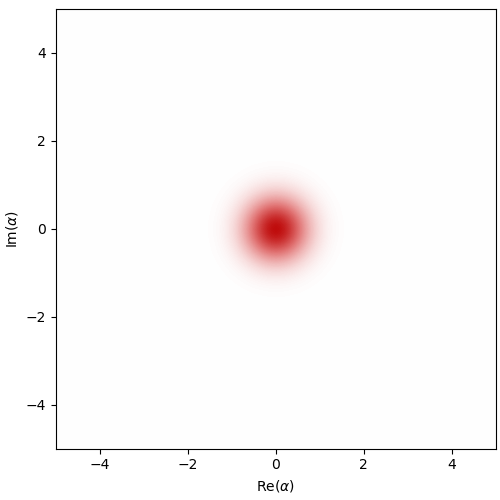

In [3]:
# Draw the Wigner function of memory mode a (as a GIF). To do this we trace out mode b.
rho_a = dq.ptrace(result.states, 0)
a_gif = dq.plot.wigner_gif(rho_a)
a_gif

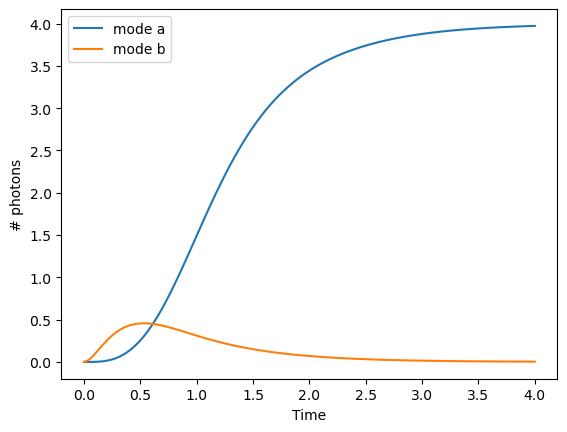

In [4]:
plt.plot(t_save, result.expects[0].real, label="mode a")
plt.plot(t_save, result.expects[1].real, label="mode b")
plt.xlabel("Time")
plt.ylabel("# photons")
plt.legend()

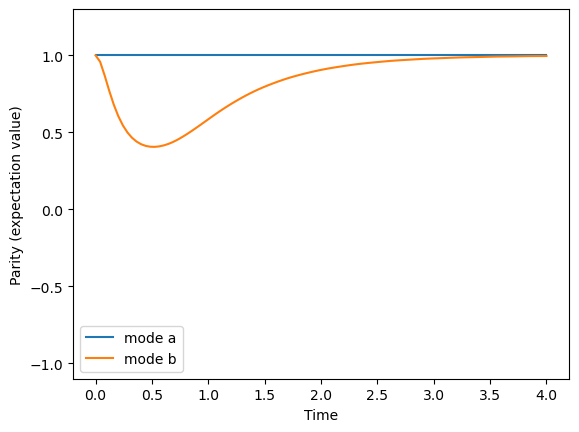

In [5]:
rho_b = dq.ptrace(result.states, 1)

plt.plot(t_save, dq.expect(dq.parity(n_a), rho_a).real, label="mode a")
plt.plot(t_save, dq.expect(dq.parity(n_b), rho_b).real, label="mode b")
plt.xlabel("Time")
plt.ylabel("Parity (expectation value)")
plt.ylim(-1.1, 1.3)
plt.legend()

## Task 1.2: Comparison with Eliminated Buffer Mode

The goal of this task is to compare the dynamics of the two-mode system from Task 1.1 with a simplified one-mode approximation, where the buffer mode is adiabatically eliminated. In this approximation, the memory mode evolves under purely dissipative dynamics governed by:

$$
\frac{d \hat{\rho}_a}{d t} = \kappa_2 \mathcal{D}[\hat{a}^2 - \alpha^2](\hat{\rho}_a),
$$

where:

-   $\kappa_2 = \frac{4|g_2|^2}{\kappa_b}$ is the two-photon dissipation rate,
-   $\alpha^2 = -\frac{\epsilon_d}{g_2^*}$ is the cat amplitude.

### Objectives

1. Simulate the time evolution of the memory mode using the one-mode approximation.
2. Compute the fidelity between the states obtained from the two-mode system (Task 1.1) and the one-mode approximation.
3. Investigate the effect of lowering $\kappa_b$ (buffer decay rate) on the fidelity.

### Parameters

-   **Two-mode system**:

    -   $n_a = 20$: Hilbert-space truncation for mode $a$,
    -   $n_b = 5$: Hilbert-space truncation for mode $b$,
    -   $g_2 = 1.0$: Coupling strength,
    -   $\epsilon_d = -4$: Drive amplitude,
    -   $\kappa_b$: Decay rate of mode $b$.

-   **One-mode approximation**:
    -   $n_a = 20$: Hilbert-space truncation for mode $a$,
    -   $\kappa_2$: Two-photon dissipation rate,
    -   $\alpha^2$: Cat amplitude.


In [6]:
# Same parameters from before
n_a = 20
g_2 = 1.0
epsilon_d = -4
kappa_b = 10
T = 4.0

# New parameters
kappa_2 = (4 * jnp.abs(g_2)**2) / kappa_b # two-photon dissipation rate
alpha_squared = -epsilon_d / jnp.conj(g_2) # cat amplitude (amplitude of the coherent state)

a = dq.destroy(n_a)
a_dag = a.dag()
psi_0 = dq.fock(n_a, 0)

H = dq.zeros(n_a)
loss_op = jnp.sqrt(kappa_2) * (a @ a - alpha_squared * dq.eye(n_a))
exp_ops = [a_dag @ a]

result = dq.mesolve(H, [loss_op], psi_0, t_save, exp_ops=exp_ops)

|██████████| 100.0% ◆ elapsed 13.76ms ◆ remaining 0.00ms


100%|██████████| 50/50 [00:01<00:00, 27.90it/s]


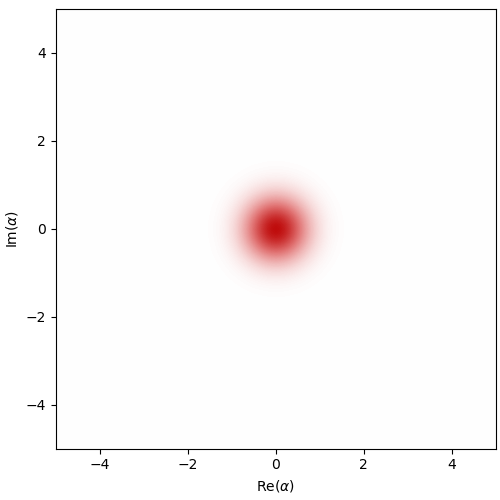

In [7]:
dq.plot.wigner_gif(result.states)

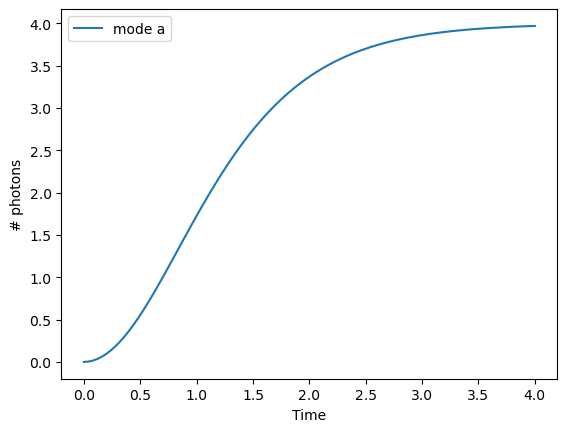

In [8]:
plt.plot(t_save, result.expects[0].real, label="mode a")
plt.xlabel("Time")
plt.ylabel("# photons")
plt.legend()
plt.show()

|██████████| 100.0% ◆ elapsed 116.99ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 15.94ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 110.32ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 12.22ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 91.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 12.27ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 79.77ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 11.30ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 67.51ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 24.44ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 54.99ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 12.26ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 42.08ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 10.56ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 31.76ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 11.58ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.36ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapse

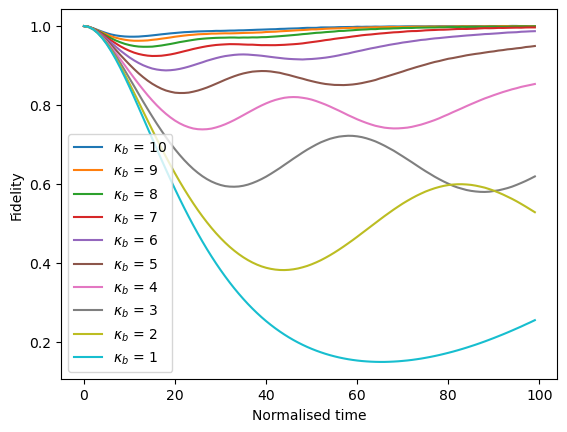

In [9]:
def simulate_two_mode_system_with_buffer(T, kappa_b, g_2=1.0, epsilon_d=-4, n_a=20, n_b=5):
    # Initial state
    psi0 = dq.fock((n_a, n_b), (0, 0))

    # Creation and annihilation operators
    a, b = dq.destroy(n_a, n_b)
    a_dag = a.dag()
    b_dag = b.dag()

    # Hamiltonian
    H_2ph = g_2 * a_dag @ a_dag @ b + jnp.conj(g_2) * a @ a @ b_dag
    H_d = jnp.conj(epsilon_d) * b + epsilon_d * b_dag
    H = H_2ph + H_d

    # Loss operator
    loss_op = jnp.sqrt(kappa_b) * b

    # Time evolution
    t_save = jnp.linspace(0, T, 100)
    result = dq.mesolve(H, [loss_op], psi0, t_save)

    # Trace out mode b to get the density matrix of mode a
    return dq.ptrace(result.states, 0)

# One-mode approximation with purely dissipative dynamics
def simulate_dissipative_one_mode_approximation(T, kappa_b, g_2=1.0, epsilon_d=-4, n_a=20):
    kappa_2 = (4 * jnp.abs(g_2)**2) / kappa_b # two-photon dissipation rate
    alpha_squared = -epsilon_d / jnp.conj(g_2) # cat amplitude (amplitude of the coherent state)
    
    # Initial state
    psi0 = dq.fock(n_a, 0)

    # Annihilation operator
    a = dq.destroy(n_a)

    # Hamiltonian
    H = dq.zeros(n_a)

    # Loss operator
    loss_op = jnp.sqrt(kappa_2) * (a @ a - alpha_squared * dq.eye(n_a))

    # Time evolution
    t_save = jnp.linspace(0, T, 100)
    result = dq.mesolve(H, [loss_op], psi0, t_save)

    return result

# Parameters
kappa_b_original = 10
T = 4.0

# Compare fidelities of states undergoing full two-mode dynamics with the one-mode dissipative approximation across 
# different values of kappa_b (buffer decay rate)
for kappa_b in range(kappa_b_original, 0, -1):    
    # Rescale simulation time so that the evolution duration remains comparable across different kappa_b values.
    # This ensures the effective dissipation (∝ kappa_b × time) is constant for fair comparison.
    T_normalised = T * (kappa_b / kappa_b_original)

    # Simulate the two-mode system with buffer
    rho_usual = simulate_two_mode_system_with_buffer(T_normalised, kappa_b)

    # Simulate the one-mode approximation with purely dissipative dynamics (assumes buffer mode is adiabatically eliminated)
    # The approximation is expected to be accurate for large kappa_b
    results_approx = simulate_dissipative_one_mode_approximation(T_normalised, kappa_b)

    fidelity = dq.fidelity(rho_usual, results_approx.states)
    plt.plot(fidelity, label=f"$\\kappa_b$ = {kappa_b}")

plt.xlabel("Normalised time")
plt.ylabel("Fidelity")
plt.legend()
plt.show()

For large $\kappa_b$, the one-mode approximation is well matched to the original two-mode system.

However, as $\kappa_b$ decreases, the differences between the two approaches become more pronounced.


## Task 1.3: Performing a Zeno Gate

The goal is to perform a continuous $Z(\theta)$ rotation, also called a Zeno gate. We are told the Hamiltonian that generates it has the form:

$$
\hat{H}_Z = \epsilon_Z^* \hat{O} + \epsilon_Z \hat{O}^\dagger,
$$

where $\hat{O}$ is a bosonic operator. The parameter $\epsilon_Z$ controls the rotation speed. Note that the logical $X$-eigenstates $\lvert \pm \rangle$ are defined by the cat states $\lvert \mathcal{C}_\alpha^\pm \rangle$.

### Objectives

a) Apply Zeno gate

-   Simulate the time evolution that maps $\lvert + \rangle$ to $\lvert - \rangle$ in a time $T_Z$, where $2T_Z$ represents a full rotation.

b) In a real-world scenario, the memory mode is also subject to single-photon losses.

-   Add a single-photon loss term for mode $a$ with loss rate $\kappa_a$
-   Plot the parity as a function of time for various values of $\kappa_a \in [0.01, 2]$ and $\epsilon_Z$.
-   For $\kappa_a \in [0.01, 2]$, determine the optimal times $T_Z$ for a rotation of $\theta = 0 \rightarrow \pi$ .


|██████████| 100.0% ◆ elapsed 44.01ms ◆ remaining 0.00ms


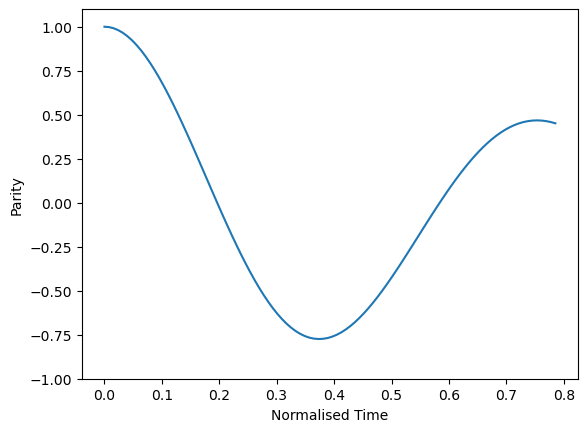

In [10]:
from IPython.display import display

n_a = 20
n_b = 5
epsilon_d = -4
kappa_b = 10
g_2 = 1.0
alpha = jnp.sqrt(-1.0*epsilon_d/g_2)

def zeno(epsilon_z, kappa_a=0.0):
    # Initial system state
    mode_a_init_state = dq.unit(dq.coherent(n_a, alpha) + dq.coherent(n_a, -alpha)) # Logical plus |+>
    mode_b_init_state = dq.fock(n_b, 0) # vacuum state
    psi0 = dq.tensor(mode_a_init_state, mode_b_init_state)
    
    theta = jnp.pi # angle to rotate
    T_z = theta / ( 4* alpha * epsilon_z)
    T = 2 * T_z # full rotation
    # T = T_z # half-rotation
    
    a, b = dq.destroy(n_a, n_b)
    a_dag, b_dag = dq.dag(a), dq.dag(b)

    # Hamiltonian
    H_2ph = g_2 * a_dag @ a_dag @ b + jnp.conj(g_2) * a @ a @ b_dag
    H_d = jnp.conj(epsilon_d) * b + epsilon_d * b_dag
    H_z = jnp.conj(epsilon_z)*a + epsilon_z*a_dag
    H = H_2ph + H_d + H_z

    exp_ops = [dq.dag(a) @ a, dq.dag(b) @ b]
    loss_op = [jnp.sqrt(kappa_b) * b, jnp.sqrt(kappa_a)*a]
    
    t_save = jnp.linspace(0, T, 100)
    res = dq.mesolve(H, loss_op, psi0, t_save, exp_ops=exp_ops)
    rho_a = dq.ptrace(res.states, 0)
    return rho_a, t_save


    
epsilon_z = 1
kappa_a = 0.0
rho, t_save = zeno(epsilon_z, kappa_a)

# wigner_gif = dq.plot.wigner_gif(rho)
# display(wigner_gif)

# Plot the parity expectation value
plt.plot(t_save, dq.expect(dq.parity(n_a), rho).real)
plt.ylim(-1, 1.1)
plt.ylabel("Parity")
plt.xlabel("Normalised Time")
plt.show()

In [11]:
a, b = dq.destroy(n_a, n_b)
a_dag, b_dag = dq.dag(a), dq.dag(b)
H_2ph = g_2 * a_dag @ a_dag @ b + jnp.conj(g_2) * a @ a @ b_dag
H_d = jnp.conj(epsilon_d) * b + epsilon_d * b_dag

epsilon_z = jnp.linspace(0.125,jnp.pi,10)
T_z = jnp.pi/(4*alpha*epsilon_z)
kappa_a = jnp.linspace(0.01,2,10)
exp = []
    
for e in epsilon_z:
    exp_per_eps = []

    for k in kappa_a:
        rho_a, t = zeno(e,k)
        z = dq.expect(dq.parity(n_a), rho_a).real.tolist()[-1]
        exp_per_eps.append(z)

    exp.append(exp_per_eps)

save_j = []
save_i = []
min_row = 0

for i in range(len(exp)):
    save_j.append(min(exp[1]))
    save_i.append(exp[i].index(min(exp[i])))

i = save_j.index(min(save_j))
j = save_i[i]

T_z_optimal = jnp.pi/(4 * alpha * epsilon_z[i])
print("Optimal T_z : " + str(T_z_optimal))
print("Optimal Kappa_a : " + str(kappa_a[j]))


|██████████| 100.0% ◆ elapsed 299.36ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 346.31ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 402.41ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 394.25ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 371.12ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 370.42ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 437.98ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 380.84ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 394.70ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 415.22ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 95.31ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 90.39ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 93.09ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 93.84ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 101.38ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 97.54ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 99.99ms ◆ remaining 0.00ms


Optimal T_z : 3.1415927
Optimal Kappa_a : 0.23111111


## Task 1.4: Optimal Control for State-Preparation

In Task 1.1, we assumed that the parameter $\epsilon_d$ in $\hat{H}_d$ was constant throughout the time evolution. Here, we explore how allowing $\epsilon_d(t)$ to vary with time can improve the state-preparation process.

### Objectives

-   Optimise $\epsilon_d(t)$ to inflate a cat state from the vacuum to a target value of $\alpha^2 = 4$ within a given time $T = 3$.
-   Plot the optimised $\epsilon_d(t)$.
-   Investigate the effect of increasing or decreasing $T$ on the optimal $\epsilon_d(t)$.

We can assume $\hat{H}_d$ is piecewise constant.


In [12]:
import jax

def simulate(epsilon_d_vals):
    n_a, n_b = 20, 5
    a, b = dq.destroy(n_a, n_b)
    a_dag, b_dag = a.dag(), b.dag()
    psi_0 = dq.fock((n_a, n_b), (0, 0))

    g_2 = 1.0
    kappa_b = 10

    T = 3.0
    t_save = jnp.linspace(0, T, 100)

    times = jnp.linspace(0, T, len(epsilon_d_vals) + 1)
    values = jnp.array(list(1 for _ in range(len(epsilon_d_vals))))
    qarray = g_2 * a_dag @ a_dag @ b + jnp.conj(g_2) * a @ a @ b_dag
    H_2ph = dq.pwc(times, values, qarray)

    # Assuming epsilon_d is a real number so that (values[i] * qarray) = ε(b + b^†) satisfies the form for the buffer drive Hamiltonian
    values = jnp.array(epsilon_d_vals)
    qarray = b + b_dag 
    H_d = dq.pwc(times, values, qarray)
    
    H = H_2ph + H_d
    loss_op = jnp.sqrt(kappa_b) * b
    exp_op = a_dag @ a

    return dq.mesolve(H, [loss_op], psi_0, t_save, exp_ops=[exp_op], options=dq.Options(progress_meter=False))

def cost(epsilon_d_vals):
    result = simulate(epsilon_d_vals)
    
    alpha_squared = 4
    errors = alpha_squared - result.expects[0].real

    return jnp.mean((errors)**2)

def optimise_epsilon_d(num_bins, init_epsilon_d_vals=None, epochs=20, learning_rate=0.1):    
    if init_epsilon_d_vals is None:
        epsilon_d_vals = jnp.ones(num_bins) * -4.0
    else:
        epsilon_d_vals = jnp.array(init_epsilon_d_vals)
    
    # get_cost_grad = jax.grad(cost)
    get_cost_grad = jax.value_and_grad(cost)  # Compute cost and gradient together
    cost_history = []

    print("Initial epsilon_d_vals:", epsilon_d_vals)
    current_cost, cost_grad = get_cost_grad(epsilon_d_vals)
    print("Initial cost:", current_cost)
    
    for i in range(epochs - 1):
        epsilon_d_vals -= learning_rate * cost_grad
        current_cost, cost_grad = get_cost_grad(epsilon_d_vals)
        cost_history.append(current_cost)
        print(f"Epoch {i+1}: Cost={cost(epsilon_d_vals)}, Epsilon_d_vals={epsilon_d_vals}")

    return epsilon_d_vals, cost_history

Initial epsilon_d_vals: [-4. -4. -4. -4. -4. -4. -4. -4. -4. -4.]
Initial cost: 5.0677795
Epoch 1: Cost=5.043965816497803, Epsilon_d_vals=[-4.0197487 -4.0182004 -4.015248  -4.011487  -4.007941  -4.0052614
 -4.0034356 -4.0021577 -4.0011067 -4.000239 ]
Epoch 2: Cost=5.0204339027404785, Epsilon_d_vals=[-4.0394382 -4.0363197 -4.030397  -4.022861  -4.015774  -4.010437
 -4.006811  -4.004277  -4.0021944 -4.0004745]
Epoch 3: Cost=4.997178077697754, Epsilon_d_vals=[-4.0590687 -4.0543585 -4.045448  -4.0341225 -4.0234995 -4.015528
 -4.0101275 -4.0063596 -4.003264  -4.000706 ]
Epoch 4: Cost=4.974194049835205, Epsilon_d_vals=[-4.0786405 -4.0723166 -4.0604005 -4.0452724 -4.0311193 -4.0205355
 -4.013386  -4.0084057 -4.0043154 -4.000934 ]
Epoch 5: Cost=4.95148229598999, Epsilon_d_vals=[-4.0981536 -4.090194  -4.075255  -4.0563107 -4.038634  -4.0254602
 -4.0165863 -4.010416  -4.005349  -4.001158 ]
Epoch 6: Cost=4.929035663604736, Epsilon_d_vals=[-4.117608  -4.1079917 -4.0900116 -4.067238  -4.046044  -4.

Array([-7.8612623, -6.896476 , -5.70068  , -4.7201443, -4.398041 ,
       -4.27966  , -4.1824355, -4.110326 , -4.06105  , -4.0156317],      dtype=float32)

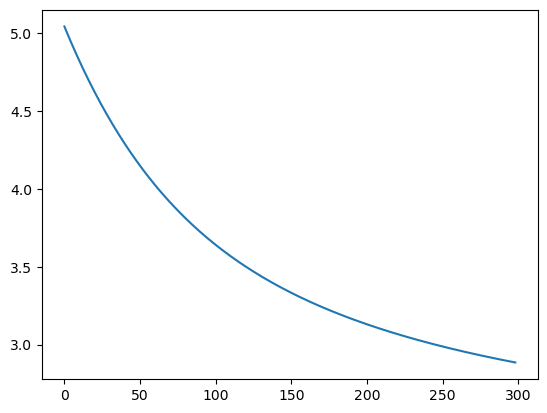

In [13]:
num_bins = 10
trained_epsilon_d, cost_history = optimise_epsilon_d(num_bins, epochs=300, learning_rate=0.05)
plt.plot(cost_history)
trained_epsilon_d

Text(0, 0.5, '$\\epsilon_d$')

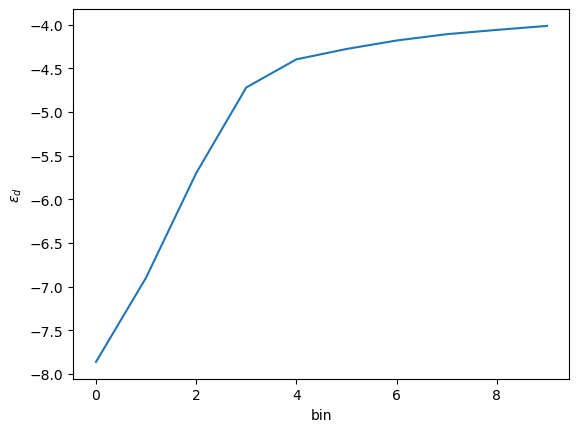

In [14]:
# plot the optimised epsilon_d values
plt.plot(trained_epsilon_d, label="Optimised epsilon_d")
plt.xlabel("bin")
plt.ylabel(f"$\\epsilon_d$")

A stronger drive amplitude, $\epsilon_d$, seems better for the initial time evolution.
We want to fit a polynomial to the trained epsilon_d values so that we can generate better initial values for future iterations of training.


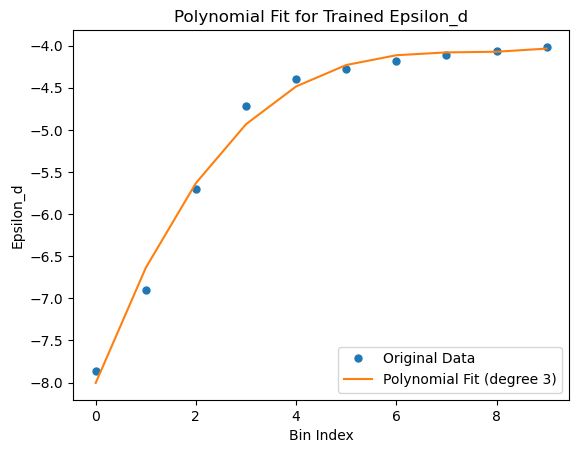

Polynomial coefficients: [ 0.00933733 -0.20918606  1.56737865 -8.00478179]


In [15]:
import numpy as np

# Given trained epsilon_d values
trained_epsilon_d = np.array([-7.8612623, -6.896476, -5.70068, -4.7201443, -4.398041,
                              -4.27966, -4.1824355, -4.110326, -4.06105, -4.0156317])

# Generate x values (bin indices)
num_bins = len(trained_epsilon_d)
x = np.arange(num_bins)

degree = 3
coefficients = np.polyfit(x, trained_epsilon_d, degree)

# Create a polynomial function from the coefficients
polynomial_fit = np.poly1d(coefficients)

# Generate fitted values for the curve
fitted_values = polynomial_fit(x)

# Plot the original data and the polynomial fit
plt.plot(x, trained_epsilon_d, 'o', label='Original Data', markersize=5)
plt.plot(x, fitted_values, '-', label=f'Polynomial Fit (degree {degree})')
plt.xlabel('Bin Index')
plt.ylabel('Epsilon_d')
plt.legend()
plt.title('Polynomial Fit for Trained Epsilon_d')
plt.show()

# Print the polynomial coefficients
print("Polynomial coefficients:", coefficients)

[-8.00478179 -6.63725187 -5.63207006 -4.93321238 -4.48465482 -4.23037341
 -4.11434414 -4.08054302 -4.07294606 -4.03552926]
Initial epsilon_d_vals: [-8.004782  -6.637252  -5.63207   -4.9332123 -4.484655  -4.2303734
 -4.114344  -4.080543  -4.072946  -4.035529 ]
Initial cost: 2.8951619
Epoch 1: Cost=2.893186330795288, Epsilon_d_vals=[-8.013049  -6.642375  -5.6326537 -4.93148   -4.4837875 -4.2304835
 -4.114722  -4.080773  -4.072995  -4.0355287]
Epoch 2: Cost=2.891221523284912, Epsilon_d_vals=[-8.021297  -6.647483  -5.633227  -4.9297504 -4.482927  -4.2305946
 -4.115097  -4.0810003 -4.073043  -4.0355277]
Epoch 3: Cost=2.8892662525177, Epsilon_d_vals=[-8.029527  -6.6525755 -5.6337895 -4.928024  -4.4820724 -4.230707
 -4.11547   -4.081225  -4.0730896 -4.0355268]
Epoch 4: Cost=2.8873214721679688, Epsilon_d_vals=[-8.037737  -6.6576533 -5.6343417 -4.9263005 -4.4812245 -4.230821
 -4.1158404 -4.081447  -4.073135  -4.0355253]
Epoch 5: Cost=2.885385751724243, Epsilon_d_vals=[-8.045929  -6.662716  -5.6

Array([-10.566823 ,  -8.206324 ,  -5.5540886,  -4.574802 ,  -4.4780087,
        -4.3089566,  -4.162706 ,  -4.0937605,  -4.0681605,  -4.033544 ],      dtype=float32)

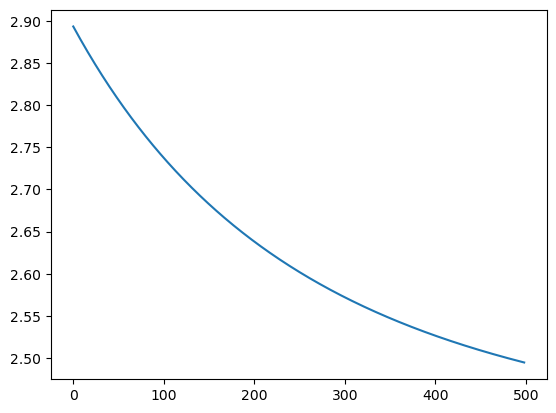

In [16]:
init_epsilon_d = polynomial_fit(np.arange(num_bins))
print(init_epsilon_d)

trained_epsilon_d, cost_history = optimise_epsilon_d(num_bins, init_epsilon_d_vals=init_epsilon_d, epochs=500, learning_rate=0.05)
plt.plot(cost_history)
trained_epsilon_d

In [17]:
result_optimised = simulate(trained_epsilon_d)
result_constant = simulate([-4.0 for _ in range(num_bins)])

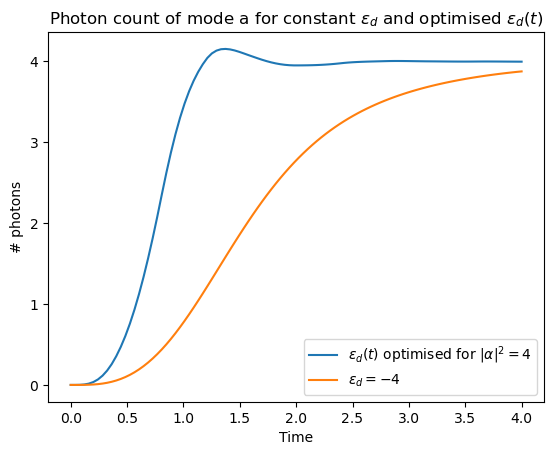

100%|██████████| 50/50 [00:01<00:00, 26.04it/s]


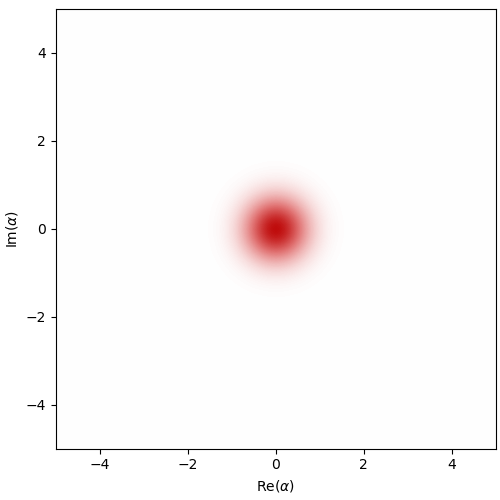

In [18]:
plt.plot(result.tsave, result_optimised.expects[0].real, label=f"$\\epsilon_d(t)$ optimised for $|\\alpha|^2 = 4$")
plt.plot(result.tsave, result_constant.expects[0].real, label="$\\epsilon_d = -4$")
plt.title(f"Photon count of mode a for constant $\\epsilon_d$ and optimised $\\epsilon_d(t)$")
plt.xlabel("Time")
plt.ylabel("# photons")
plt.legend()
plt.show()

gif = dq.plot.wigner_gif(dq.ptrace(result_optimised.states, 0))
gif

# Task 2 - Simulate the dynamics of cat qubits at the circuit level


## Task 2.1: Lab Frame Simulation

Simulate the dynamics of cat qubits at the circuit level using the Lindblad master equation:

$$\frac{d \hat{\rho}}{dt} = \mathcal{L}[\hat{\rho}] = -i \left[\hat{H}, \hat{\rho}\right] + \kappa_b \mathcal{D}(\hat{b})[\hat{\rho}] +  \kappa_a \mathcal{D}(\hat{a})[\hat{\rho}]$$

At the saddle point ($\varphi_\Sigma = \pi/2 + \epsilon(t)$, $\varphi_\Delta = \pi/2$), the Hamiltonian in the lab frame is:

$$
\begin{aligned}
\hat{H} &= \hat{H}_0 + \hat{H}_{\mathrm{ATS}} + \hat{H}_d,\qquad \mathrm{with}\\
\hat{H}_0 &= \omega_{a,0}\hat{a}^\dagger \hat{a} + \omega_{b,0} \hat{b}^\dagger \hat{b}\\
\hat{H}_{ATS} &= -2 E_J \sin(\epsilon(t)) \sin(\hat{\varphi}) +2 \Delta E_J \cos(\epsilon(t)) \cos(\hat{\varphi}),\\
\hat{H}_d &= 2 \epsilon_d \cos(\omega_d t) \left(\hat{b} +  \hat{b}^\dagger\right).
\end{aligned}
$$

Here, $\epsilon(t) = \epsilon_p \cos(\omega_p t)$.

### Parameters

-   $\omega_{a,0}/2\pi = 5.26\; \mathrm{GHz}$
-   $\omega_{b,0}/2\pi = 7.70\; \mathrm{GHz}$
-   $\varphi_a = 0.06$
-   $\varphi_b = 0.29$
-   $E_J/h = 12.03\; \mathrm{GHz}$
-   $\Delta E_J / h = 0.47\;\mathrm{GHz}$
-   $\omega_d/2\pi = 7.623 \; \mathrm{GHz}$
-   $\omega_p/2\pi = 2.891 \; \mathrm{GHz}$
-   $\epsilon_d/2\pi = -3.815 \; \mathrm{MHz}$
-   $\epsilon_p = 0.122 \; \mathrm{rad}$

### Objective

Starting from the vacuum in modes $a$ and $b$, simulate the time evolution of the system for $T = X \; \mu \mathrm{s}$. Plot the evolution of the Wigner function in mode $a$.


/Users/kostas/anaconda3/envs/quantum/lib/python3.12/site-packages/equinox/_module.py:1041: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
|██████████| 100.0% ◆ elapsed 57.17s ◆ remaining 0.00ms  
100%|██████████| 125/125 [00:04<00:00, 27.32it/s]


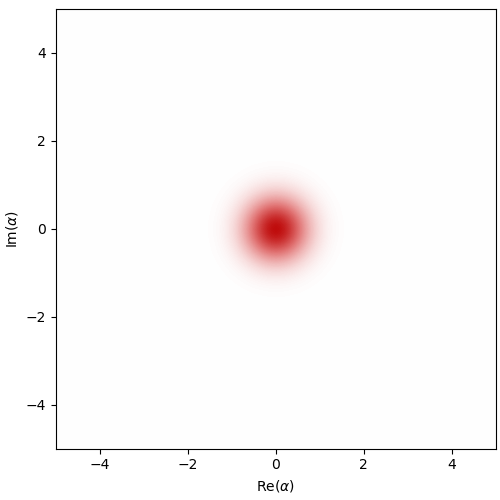

In [19]:
# Annihilation and creation operators
n_a, n_b = 20, 5
a, b = dq.destroy(n_a, n_b)
a_dag, b_dag = a.dag(), b.dag()

# Units
GHz = 1.0 # Relativise parameters to 1 GHz. Avoid defining MHz and KHz variables to prevent floating-point precision errors that can arise when scaling by small factors.

# Parameters (from https://arxiv.org/abs/2307.06617 and Task 2.1 statement)
omega_a_0 = 5.26
omega_b_0 = 7.7
phi_a = 0.06
phi_b = 0.29
E_j = 12.03 # Referenced paper states E_j = 12.03 GHz
Delta_E_j = 0.47
omega_d = 7.623
omega_p = 2.891
kappa_a = 9.3e-6 # energy damping rate of mode a (memory mode)
kappa_b = 2.6e-3 # energy damping rate of mode b (lossy buffer mode)

g2_target = 0.763e-3 # target g2 used to specify driving strength of ATS
alpha_target = jnp.sqrt(5.0) # target alpha, (or equivalently specify number of photons)

# Driving strengths
epsilon_p = 2*g2_target/(E_j * phi_a**2 * phi_b) # flux pump power
epsilon_d = -alpha_target**2 * jnp.conj(g2_target) # buffer pump power
epsilon_ats = lambda t: epsilon_p * jnp.cos(omega_p * t) # ATS driving term

phi = phi_a * (a + a_dag) + phi_b * (b + b_dag)
sin_phi = dq.sinm(phi)
cos_phi = dq.cosm(phi)

# Initial state
psi_0 = dq.fock((n_a, n_b), (0, 0))

# Hamiltonian
H_0 = omega_a_0 * (a_dag @ a) + omega_b_0 * (b_dag @ b)

H_ATS =  dq.modulated(lambda t: (-2 * E_j * jnp.sin(epsilon_ats(t))), sin_phi) \
       + dq.modulated(lambda t: (2 * Delta_E_j * jnp.cos(epsilon_ats(t))), cos_phi)

H_d = dq.modulated(lambda t: 2 * epsilon_d * jnp.cos(omega_d * t), (b + b_dag))

H = H_0 + H_ATS + H_d

# Loss operators
jump_ops = [jnp.sqrt(kappa_b) * b, jnp.sqrt(kappa_a) * a]

T = 300
t_save = jnp.linspace(0, T, 200)

result = dq.mesolve(H, jump_ops, psi_0, t_save)

rho_a = dq.ptrace(result.states,0)
gifa = dq.plot.wigner_gif(rho_a, fps=25)

display(gifa)

### Task 2.2: Rotated-Displaced Frame Simulation

#### Objective:

-   Find the rotated-displaced frame for the system
-   Simulate the time evolution of the system in the rotated-displaced frame with the same parameters as in Task 2.1. Compare the Wigner function evolution in mode $a$ with the previous frame. Observe how the dynamics differ in the rotated-displaced frame.


In [20]:
#initialization:
delta_a, delta_b = (0.0,0.0) # set initial AC Stark shifts to zero
omega_p = 2*omega_a_0 - omega_b_0 # initial frequency matching condition

#recursion loop to compute AC Stark shift:
rec_depth = 30
for i in range(rec_depth):
    #compute xi for mode a and b:
    alpha_1 = 1j*E_j*epsilon_p*phi_a / (kappa_a/2 + 1j*(omega_a_0 - omega_p))
    alpha_2 = 1j*E_j*epsilon_p*phi_a / (kappa_a/2 + 1j*(omega_a_0 + omega_p))

    beta_1 = 1j*E_j*epsilon_p*phi_b / (kappa_b/2 + 1j*(omega_b_0 - omega_p))
    beta_2 = 1j*E_j*epsilon_p*phi_b / (kappa_b/2 + 1j*(omega_b_0 + omega_p))

    pre = (np.real(alpha_1) + np.real(alpha_2)) * phi_a \
    + (np.real(beta_1) + np.real(beta_2)) * phi_b
    #compute AC Stark shifts:
    delta_a = 1/3*E_j * epsilon_p * phi_a**2 * pre 
    delta_b = 1/3*E_j * epsilon_p * phi_b**2 * pre 

    #recompute frequencies
    omega_a = omega_a_0 - 2*Delta_E_j*phi_a**2 + delta_a 
    omega_b = omega_b_0 - 2*Delta_E_j*phi_b**2 + delta_b 
    omega_p = 2*omega_a - omega_b

omega_d = omega_b

/Users/kostas/anaconda3/envs/quantum/lib/python3.12/site-packages/equinox/_module.py:1041: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
/var/folders/q4/v9gppjdn62q77029lkw_3gh80000gn/T/ipykernel_92872/4217719144.py:49: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return h_0 + h_ats + h_buffer_drive + h_rot + h_dis
/Users/kostas/anaconda3/envs/quantum/lib/python3.12/site-packages/dynamiqs/qarrays/qarray.py:552: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return self.__add__(y)
|██████████| 100.0% ◆ elapsed 20.46s ◆ remaining 0.00ms  
100%|██████████| 125/125 [00:04<00:00, 28.77it/s]


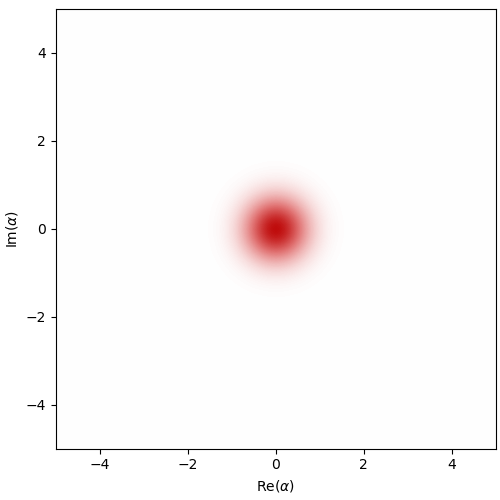

In [21]:
# define the ATS driving term
eps_ats = lambda t: epsilon_p*jnp.cos(omega_p*t)
identity = dq.tensor(dq.eye(n_a), dq.eye(n_b))

def op_rot_displaced(t, op, omega_rot, dis):
    return op*jnp.exp(-1j*omega_rot*t) + dis * identity

def hamiltonian_rotating_displaced(t):
    #compute displacement fields
    alpha_t = alpha_1*jnp.exp(-1j*omega_p*t) + alpha_2*jnp.exp(1j*omega_p*t)
    beta_t = beta_1*jnp.exp(-1j*omega_p*t) + beta_2*jnp.exp(1j*omega_p*t)

    # the displaced rotating frame introduces a drive and detuning
    d_alpha_t = 1j*omega_p * (alpha_2*jnp.exp(1j*omega_p*t) - alpha_1*jnp.exp(-1j*omega_p*t))
    d_beta_t = 1j*omega_p * (beta_2*jnp.exp(1j*omega_p*t) - beta_1*jnp.exp(-1j*omega_p*t))

    #compute rotated displaced operators:
    # omega_rot_a = (omega_p + omega_d) / 2
    omega_rot_a = omega_a
    omega_rot_b = omega_d
    a_f = op_rot_displaced(t, a, omega_rot_a, alpha_t)
    b_f = op_rot_displaced(t, b, omega_rot_b, beta_t)
    adag_f = a_f.dag()
    bdag_f = b_f.dag()

    #displaced rotated phase operator
    phi_f = phi_a*(a_f + adag_f) + phi_b*(b_f + bdag_f)

    #linear term
    h_0 = omega_a_0 * adag_f @ a_f + omega_b_0 * bdag_f @ b_f
    
    #term from derivative of rotating frame
    h_rot = -omega_rot_a * dq.dag(a) @ a  - omega_rot_b * dq.dag(b) @ b
    
    #term from derivative of displaced frame
    h_dis =  -1j*(d_alpha_t*dq.dag(a)*jnp.exp(1j*omega_rot_a*t)-jnp.conj(d_alpha_t)*a*jnp.exp(-1j*omega_rot_a*t)) \
      - 1j*(d_beta_t*dq.dag(b)*jnp.exp(1j*omega_rot_b*t)-jnp.conj(d_beta_t)*b*jnp.exp(-1j*omega_rot_b*t))
        
    #ats term:
    sinterm = jnp.sin(eps_ats(t)) * dq.sinm(phi_f)
    costerm = jnp.cos(eps_ats(t)) * dq.cosm(phi_f)
    h_ats = - 2*E_j*sinterm +  2*Delta_E_j*costerm 
    
    #drive on the buffer:
    # in the rotating frame, this term is non-rotating
    h_buffer_drive = jnp.conj(epsilon_d)*jnp.exp(1j*omega_d*t)*b_f \
        + epsilon_d * jnp.exp(-1j*omega_d*t) * bdag_f
    
    return h_0 + h_ats + h_buffer_drive + h_rot + h_dis

# Make Hamiltonian time-callable JAX function:
H = dq.timecallable(hamiltonian_rotating_displaced)

jump_ops = [jnp.sqrt(kappa_b) * b, jnp.sqrt(kappa_a) * a]

T = 300
t_save = jnp.linspace(0, T, 200)

result = dq.mesolve(H, jump_ops, psi_0, t_save)

rho_a_rot_disp_circ_hamiltonian = dq.ptrace(result.states,0)
rho_b = dq.ptrace(result.states,1)
gif = dq.plot.wigner_gif(rho_a_rot_disp_circ_hamiltonian, fps=25)

display(gif)

### Task 2.3: Comparison with Effective Model

Compare the results obtained from the rotated-displaced circuit Hamiltonian simulation (Task 2.2) with the effective model introduced in Task 1.1.

#### Objective:

-   Plot the fidelity between the states of mode $a$ (memory mode) from the two simulations as a function of time using `dq.fidelity`. What do you observe?


|██████████| 100.0% ◆ elapsed 10.80s ◆ remaining 0.00ms  


Text(0.5, 1.0, 'Memory mode fidelity of states: effective vs (rotated-displaced) circuit Hamiltonian')

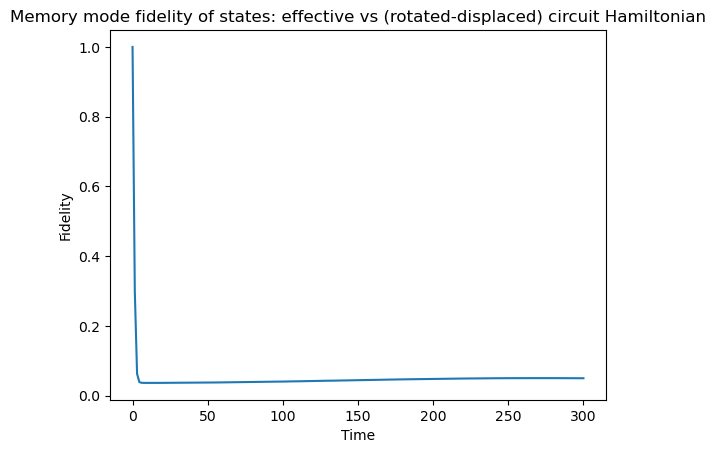

In [23]:
def task_1_1_effective_hamiltonian_simulation(t_save):
    # Parameters
    g_2 = 1.0 # coupling strength
    epsilon_d = -4 # drive amplitude
    kappa_b = 10 # decay rate of mode b

    # Initial state
    psi_0 = dq.fock((n_a, n_b), (0, 0)) 

    # Creation and annihilation operators
    a, b = dq.destroy(n_a, n_b)
    a_dag = a.dag()
    b_dag = b.dag()

    # Hamiltonian
    H_2ph = (g_2 * a_dag @ a_dag @ b) + (jnp.conj(g_2) * a @ a @ b_dag)
    H_d = jnp.conj(epsilon_d) * b + epsilon_d * b_dag
    H = H_2ph + H_d

    loss_op = jnp.sqrt(kappa_b) * b

    # Simulate time evolution
    return dq.mesolve(H, [loss_op], psi_0, t_save)


t_save = jnp.linspace(0, T, 200)
result_effective_hamiltonian = task_1_1_effective_hamiltonian_simulation(t_save)

# Fidelity between the states of mode a (memory mode) from the two simulations
rho_a_effective_hamiltonian = dq.ptrace(result_effective_hamiltonian.states, 0)
fidelities = dq.fidelity(rho_a_rot_disp_circ_hamiltonian, rho_a_effective_hamiltonian)

# Plot the fidelity
plt.plot(t_save, fidelities)
plt.xlabel('Time')
plt.ylabel('Fidelity')
plt.title('Memory mode fidelity of states: effective vs (rotated-displaced) circuit Hamiltonian')